In [1]:
import torch
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as dset
from torch.utils.data import Dataset
import numpy as np
import os

In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
pwd

'/home/praveen/projects/Speech/postnet_experiments/Postnet'

In [4]:
class Params:
    def __init__(self):
        self.batchSize = 32
        self.Stage1imageSize = 64
        self.Stage2imageSize = 64
        self.LAMBDA = 10
        self.lr= 0.0002
        self.nc = 1
        self.nz = 100
        self.ngf = 64
        self.ndf = 64
        #for unet 
        self.nc_out = 1
        self.num_downsample = 4
        self.dataroot = '/home/praveen/projects/Speech/postnet_experiments/Postnet/speech_scripts/single_npy_dumps'
        self.metadata_dir = self.dataroot
        self.workers = 1
        self.restart = 'restart'
        self.cuda = True
        self.beta1 = 0.5
opt = Params()

In [5]:
opt.nc

1

In [6]:
#Image superresolution [64x64->128x128]
#We would like to do supervised training so as to produce 128x128 images from 64x64 
#Together with this, we add adversarial terms. This is a rather roundabout way of reimplementing pix2pix maybe

In [7]:
#Pull out things from https://github.com/pytorch/vision/tree/master/torchvision/datasets to create 
#a new dataset class
#We want a dataloader that can emit both 64x64 and 128x128 data at the same time with 'enumerate'
#Then we make the generator produce 128x128 taking in 64x64 as input which we then train

In [8]:
def make_dataset(dir):
    import os
    images = []
    d = os.path.expanduser(dir)
    print('d',d)
    
    if not os.path.exists(dir):
        print('path does not exist')

    for root, _, fnames in sorted(os.walk(d)):
        print('root', root)
        for fname in sorted(fnames):
            path = os.path.join(root, fname)
            images.append(path)
    return images

In [9]:
def random_crop(source, target, cropsize=64):
    width = source.shape[0]
    height = source.shape[1]
    
    j = np.random.randint(width)
    i = np.random.randint(height)

        
    while (j+cropsize//2>width) or (j-cropsize//2<0):
        #print(j+cropsize,j-cropsize)
        j = np.random.randint(width)
        
    #print('end j',j)
    
    jplus = j+cropsize//2
    jminus = j-cropsize//2
        
    while (i+cropsize//2>height) or (i-cropsize//2<0):
        #print(i+cropsize,i-cropsize)
        i = np.random.randint(height)
        
    #print('end i', i)
    
    iplus = i+cropsize//2
    iminus = i-cropsize//2
        
    #print(jminus,jplus,iminus,iplus)
    
    cropped_source = source[jminus:jplus,iminus:iplus]
    cropped_target = target[jminus:jplus,iminus:iplus]
    
    
    return cropped_source, cropped_target
    

In [10]:
def pad_mels(source, target, padded_width=512,padded_height=128):
    padded_source = np.zeros((padded_width,padded_height))
    padded_target = np.zeros((padded_width,padded_height))
    
    width = source.shape[0]
    height = source.shape[1]
    
    padded_source[:width,:height] = source
    padded_target[:width,:height] = target
    
    return padded_source, padded_target
    
   

In [11]:
def normalize(x):
    min_x = x.min()
    max_x = x.max()

    y = 1.0-2.0*(max_x-x)/(max_x-min_x+1)

    return y
    

In [12]:
def get_mels(path,metadata_file):
    import os 
    source = []
    target = []
    
    with open(metadata_file,'r') as metafile:
        entries = [entry.split('\n')[0] for entry in metafile]
    metafile.close()
    
    for file in entries:
        src_file = np.load(os.path.join(path,'recon_'+file+'.npy'))
        tgt_file = np.load(os.path.join(path,'target_'+file+'.npy'))
        
        #cropped_src, cropped_tgt = random_crop(src_file,tgt_file)
        src_file = normalize(src_file)
        tgt_file = normalize(tgt_file)
        
        padded_src, padded_tgt = pad_mels(src_file,tgt_file)
        #padded_src = normalize(padded_src)
        #padded_tgt = normalize(padded_tgt)
        
        source.append(padded_src)
        target.append(padded_tgt)
        
    return source, target
    

In [13]:
path = os.path.join(opt.dataroot, 'train')
metadata_file = os.path.join(opt.metadata_dir,'train.txt')

In [14]:
source, target = get_mels(path,metadata_file)

In [15]:
print(len(source), len(target))

9500 9500


In [16]:
source[0].shape

(512, 128)

In [17]:
def write_image(image,output_file):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.pyplot import figure
    figure(num=None, figsize=(50, 8), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(image,origin='lower')
    plt.savefig(output_file)

In [18]:
write_image(source[4].T,'src')

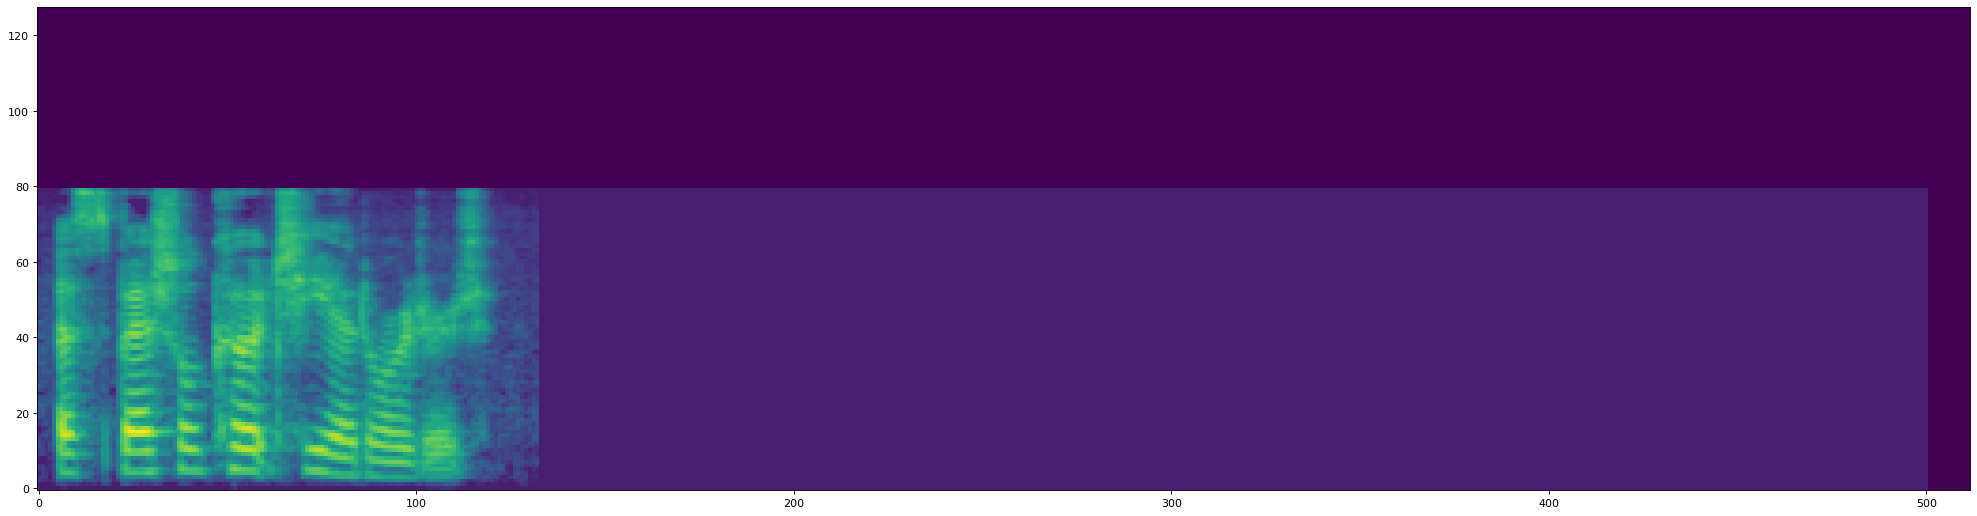

In [19]:
write_image(target[4].T,'tgt')

In [20]:
class ImageFolder(Dataset):
    """A generic data loader where the images are arranged in this way: ::
        root/dog/xxx.png
        root/dog/xxy.png
        root/dog/xxz.png
        root/cat/123.png
        root/cat/nsdf3.png
        root/cat/asd932_.png
    Args:
        root (string): Root directory path.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        loader (callable, optional): A function to load an image given its path.
        is_valid_file (callable, optional): A function that takes path of an Image file
            and check if the file is a valid_file (used to check of corrupt files)
     Attributes:
        classes (list): List of the class names.
        class_to_idx (dict): Dict with items (class_name, class_index).
        imgs (list): List of (image path, class_index) tuples
    """

    def __init__(self, data_path, metadata_file):
        #print('opt.dataroot',opt.dataroot)
        self.src_samples, self.tgt_samples = get_mels(data_path,metadata_file)
        #self.imgs = self.samples
        #self.transformA = transformA
        
        
    def __getitem__(self, index):
        """
        Args:
        index (int): Index
        Returns:
        tuple: (sample, target) where target is class_index of the target class.
        """
        #path = self.samples[index]
        #sample = pil_loader(path)
        
        #if self.transformA is not None:
        #sampleA = self.transformA(sample)
        
        return self.src_samples[index], self.tgt_samples[index]
       

    def __len__(self):
        return len(self.src_samples)


In [21]:
data_path = os.path.join(opt.dataroot, 'train')
metadata_file = os.path.join(opt.metadata_dir,'test.txt')

In [22]:
dataset = ImageFolder(data_path,metadata_file)

#Now we create a dataloader that dumps out both 64x64 and 128x128 when called with 'enumerate'
dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt.batchSize,
                                         shuffle=True, num_workers=int(opt.workers))

In [23]:
for i,(src,tgt) in enumerate(dataloader):
    print(i)
    print('src.size()',src.size())
    print('tgt.size()',tgt.size())

0
src.size() torch.Size([32, 512, 128])
tgt.size() torch.Size([32, 512, 128])
1
src.size() torch.Size([32, 512, 128])
tgt.size() torch.Size([32, 512, 128])
2
src.size() torch.Size([32, 512, 128])
tgt.size() torch.Size([32, 512, 128])
3
src.size() torch.Size([32, 512, 128])
tgt.size() torch.Size([32, 512, 128])
4
src.size() torch.Size([32, 512, 128])
tgt.size() torch.Size([32, 512, 128])
5
src.size() torch.Size([32, 512, 128])
tgt.size() torch.Size([32, 512, 128])
6
src.size() torch.Size([32, 512, 128])
tgt.size() torch.Size([32, 512, 128])
7
src.size() torch.Size([32, 512, 128])
tgt.size() torch.Size([32, 512, 128])
8
src.size() torch.Size([32, 512, 128])
tgt.size() torch.Size([32, 512, 128])
9
src.size() torch.Size([32, 512, 128])
tgt.size() torch.Size([32, 512, 128])
10
src.size() torch.Size([32, 512, 128])
tgt.size() torch.Size([32, 512, 128])
11
src.size() torch.Size([32, 512, 128])
tgt.size() torch.Size([32, 512, 128])
12
src.size() torch.Size([32, 512, 128])
tgt.size() torch.Size

In [24]:
#dataloaderStage1, dataloaderStage2 = get_data_loaders(opt)

In [25]:
#%aimport model
#from model import G_Stage1
#from model import D_Stage1
#from model import G_Stage2
#from model import D_Stage2
#from model import get_unet_generator
from model import UnetGenerator
#from model import UnetGenerator
#from model import D_Stage2_4x4

In [26]:
opt.nc

1

In [27]:
#D2 = D_Stage2(opt.nc,opt.ndf)
print(opt.nc)
G = UnetGenerator(1, 1, 4)

if opt.cuda:
    #D2 = D2.cuda()
    G = G.cuda()

1


In [28]:

print(G)

UnetGenerator(
  (model): UnetSkipConnectionBlock(
    (model): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): UnetSkipConnectionBlock(
        (model): Sequential(
          (0): LeakyReLU(negative_slope=0.2, inplace=True)
          (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): UnetSkipConnectionBlock(
            (model): Sequential(
              (0): LeakyReLU(negative_slope=0.2, inplace=True)
              (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
              (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (3): UnetSkipConnectionBlock(
                (model): Sequential(
                  (0): LeakyReLU(negative_slope=0.2, inplace=True)
                  (1): Conv2d(256, 512,

In [29]:
G.load_state_dict(torch.load('./dumps'+'/postnet_epoch_'+'35'+'.pth'))

<All keys matched successfully>

In [30]:
G = G.cuda()

In [31]:
print(src[0].size())

torch.Size([512, 128])


In [32]:
s_data = src[3].cuda()

In [33]:
print(s_data.size())

torch.Size([512, 128])


In [ ]:
s_data = s_data.unsqueeze(0).unsqueeze(0)

In [ ]:
def run_and_plot(x,G):
    x = x.unsqueeze(0).unsqueeze(0)
    y=G(x.float())
    y = y.squeeze(0).squeeze(0)
    y = y.data.cpu().numpy()
    write_image(y.T,'recon')
    return y

In [ ]:
src[3].shape

In [ ]:
cropped = src[3][:64,:64].cuda()
run_and_plot(cropped,G)

In [ ]:
write_image(src[3][:64,:64].T,'_')

In [ ]:
write_image(tgt[3][:64,:64].T,'_')

In [ ]:
write_image(src[0].T,'src')

In [ ]:
write_image(tgt[0].T,'tgt')

In [ ]:
print(y.shape)
print(src[0].shape)
print(tgt[0].shape)

In [ ]:
s = src[0]
t = tgt[0]

In [ ]:
y = y[:,:80]

In [ ]:
s = s[:,:80]
t = t[:,:80]

In [ ]:
write_image(y.T,'recon')

In [ ]:
write_image(s.T,'src')
write_image(t.T,'tgt')

In [ ]:
def display_image(image):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.pyplot import figure
    figure(num=None, figsize=(4, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(image,origin='lower')
    plt.show()

In [ ]:
def write_image(image,output_file):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.pyplot import figure
    figure(num=None, figsize=(50, 8), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(image,origin='lower')
    plt.savefig(output_file)

In [ ]:
cout = y.detach().squeeze(0).squeeze(0).cpu().numpy()
display_image(cout)

In [ ]:
display_image(cropped_source.T)

In [ ]:
display_image(cropped_target.T)

In [ ]:
display_image(source.T)

In [ ]:
display_image(target.T)

In [ ]:
write_image(source.T,'output_source')

In [ ]:
write_image(target.T,'output_target')

In [ ]:
%aimport train2
from train2 import run_trainer2

In [ ]:
run_trainer2(dataloader, G2, D2, opt)

In [ ]:
z= torch.randn(1,3,64,512)
z = z.cuda()

In [ ]:
zout = G2(z)

In [ ]:
zout.size()

In [ ]:
def plot_mel(mel):
    import matplotlib.pyplot as plt
    import numpy as np
    import librosa.display
    import os
    plt.figure(figsize=(10, 4))
    #librosa.display.specshow(librosa.power_to_db(mel,ref=np.max),
    #                         y_axis='mel', fmax=8000, x_axis='time')
    librosa.display.specshow(mel,
                             y_axis='mel', fmax=8000, x_axis='time',cmap='magma')
    #plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram ')
    plt.tight_layout()

    plt.show()
    plt.close()

In [ ]:
plot_mel(source.T)

In [ ]:
plot_mel(target.T)